<a href="https://colab.research.google.com/github/tnc-br/ddf-isoscapes/blob/new_kl/dnn/briso_d13C_boosted_residuals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Variational model

Find the mean/variance of O18 ratios (as well as N15 and C13 in the future) at a particular lat/lon across Brazil. At the bottom of the colab, train and evaluate 4 different versions of the model with different data partitioning strategies.

In [32]:
from collections import defaultdict
import math
import numpy as np
import pandas as pd
import datetime
import os
from typing import List, Tuple, Dict
from dataclasses import dataclass
from joblib import dump


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from matplotlib import pyplot as plt
from tensorflow.python.ops import math_ops
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler
from sklearn.compose import ColumnTransformer

#@title Debugging
# See https://zohaib.me/debugging-in-google-collab-notebook/ for tips,
# as well as docs for pdb and ipdb.
DEBUG = False #@param {type:"boolean"}
USE_LOCAL_DRIVE = False #@param {type:"boolean"}
LOCAL_DIR = "/usr/local/google/home/ruru/Downloads/amazon_sample_data-20230712T203059Z-001" #@param
GDRIVE_DIR = "MyDrive/amazon_rainforest_files/" #@param
FP_ROOT = LOCAL_DIR

MODEL_SAVE_LOCATION = "MyDrive/amazon_rainforest_files/variational/model" #@param

def get_model_save_location(filename) -> str:
  root = '' if USE_LOCAL_DRIVE else '/content/gdrive'
  return os.path.join(root, MODEL_SAVE_LOCATION, filename)

# Access data stored on Google Drive if not reading data locally.
if not USE_LOCAL_DRIVE:
  from google.colab import drive
  drive.mount('/content/gdrive')
  global FP_ROOT
  FP_ROOT = os.path.join('/content/gdrive', GDRIVE_DIR)

if DEBUG:
    %pip install -Uqq ipdb
    import ipdb
    %pdb on

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import sys

!if [ ! -d "/content/ddf_common_stub" ] ; then git clone -b test https://github.com/tnc-br/ddf_common_stub.git; fi
sys.path.append("/content/ddf_common_stub/")
import ddfimport
ddfimport.ddf_source_control_pane()



Cloning into 'ddf_common_stub'...
remote: Enumerating objects: 11, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 11 (delta 4), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (11/11), 5.50 KiB | 5.50 MiB/s, done.
Resolving deltas: 100% (4/4), done.


interactive(children=(Text(value='', description='Email', placeholder='Enter email'), Text(value='', descripti…

In [87]:
import raster
import importlib
importlib.reload(raster)

<module 'raster' from '/content/gdrive/MyDrive/gen_isoscape/ddf_common/raster.py'>

# Data preparation


In [90]:
def load_dataset(path: str, columns_to_keep: List[str], side_raster_input):
  df = pd.read_csv(path, encoding="ISO-8859-1", sep=',')
  df = df[df['d18O_variance'].notna()]
  X = df
  X = X.drop(df.columns.difference(columns_to_keep), axis=1)

  for name, geotiff in side_raster_input.items():
    X[name] = X.apply(lambda row: geotiff.value_at(row['long'], row['lat']), axis=1)
    # The last two kriging columns need to remain last. Move new columns forward.

  print(X.columns)

  print(X['d13C_cel_inferred'])

  X['d13C_cel'] = X['d13C_cel'].fillna(X['d13C_cel_inferred'])
  X.drop(columns=['d13C_cel_inferred'], inplace=True)

  print(X.columns)

  Y = df[["d18O_mean", "d18O_variance"]]
  return X, Y

# Standardization

In [92]:
@dataclass
class FeaturesToLabels:
  def __init__(self, X: pd.DataFrame, Y: pd.DataFrame):
    self.X = X
    self.Y = Y

  def as_tuple(self):
    return (self.X, self.Y)


def create_feature_scaler(X: pd.DataFrame,
                          columns_to_passthrough,
                          columns_to_scale,
                          columns_to_standardize) -> ColumnTransformer:
  columns_to_standardize = columns_to_standardize + ['Mean Annual Temperature', 'Mean Annual Precipitation']
  feature_scaler = ColumnTransformer(
      [(column+'_normalizer', MinMaxScaler(), [column]) for column in columns_to_scale] +
      [(column+'_standardizer', StandardScaler(), [column]) for column in columns_to_standardize],
      remainder='passthrough')
  feature_scaler.fit(X)
  print(feature_scaler)
  return feature_scaler

def create_label_scaler(Y: pd.DataFrame) -> ColumnTransformer:
  label_scaler = ColumnTransformer([
      ('mean_std_scaler', StandardScaler(), ['d18O_mean']),
      ('var_minmax_scaler', MinMaxScaler(), ['d18O_variance'])],
      remainder='passthrough')
  label_scaler.fit(Y)
  return label_scaler

def scale(X: pd.DataFrame, feature_scaler):
  # transform() outputs numpy arrays :(  need to convert back to DataFrame.
  X_standardized = pd.DataFrame(feature_scaler.transform(X),
                        index=X.index, columns=X.columns)
  return X_standardized

In [84]:
# Just a class organization, holds each scaled dataset and the scaler used.
# Useful for unscaling predictions.
@dataclass
class ScaledPartitions():
  def __init__(self,
               feature_scaler: ColumnTransformer,
               label_scaler: ColumnTransformer,
               train: FeaturesToLabels, val: FeaturesToLabels,
               test: FeaturesToLabels):
    self.feature_scaler = feature_scaler
    self.label_scaler = label_scaler
    self.train = train
    self.val = val
    self.test = test


def load_and_scale(config: Dict,
                   columns_to_passthrough: List[str],
                   columns_to_scale: List[str],
                   columns_to_standardize: List[str]) -> ScaledPartitions:

  geotiff_side_input = {
      "d13C_cel_inferred" : raster.load_raster(raster.get_raster_path("d13C_cel_map_BRAZIL_stack.tiff"), use_only_band_index=0),
      'Mean Annual Temperature': raster.temperature_geotiff(),
      'Mean Annual Precipitation': raster.brazil_map_geotiff(),
      "ordinary_kriging_linear_d18O_predicted_mean" : raster.load_raster(raster.get_raster_path("canonical/kriging_overall_means.tiff")),
      "ordinary_kriging_linear_d18O_predicted_variance" : raster.load_raster(raster.get_raster_path("canonical/kriging_overall_vars.tiff"))
  }
  columns_to_keep = columns_to_passthrough + columns_to_scale + columns_to_standardize
  X_train, Y_train = load_dataset(config['TRAIN'], columns_to_keep, geotiff_side_input)
  X_val, Y_val = load_dataset(config['VALIDATION'], columns_to_keep, geotiff_side_input)
  X_test, Y_test = load_dataset(config['TEST'], columns_to_keep, geotiff_side_input)

  # Fit the scaler:
  feature_scaler = create_feature_scaler(
      X_train,
      columns_to_passthrough,
      columns_to_scale,
      columns_to_standardize)

  # Apply the scaler:
  label_scaler = create_label_scaler(Y_train)
  train = FeaturesToLabels(scale(X_train, feature_scaler), Y_train)
  val = FeaturesToLabels(scale(X_val, feature_scaler), Y_val)
  test = FeaturesToLabels(scale(X_test, feature_scaler), Y_test)
  return ScaledPartitions(feature_scaler, label_scaler, train, val, test)


# Model Definition



The KL Loss function:

In [85]:
def sample_normal_distribution(
    mean: tf.Tensor,
    stdev: tf.Tensor,
    n: int) -> tf.Tensor:
    '''
    Given a batch of normal distributions described by a mean and stdev in
    a tf.Tensor, sample n elements from each distribution and return the mean
    and standard deviation per sample.
    '''
    batch_size = tf.shape(mean)[0]

    # Output tensor is (n, batch_size, 1)
    sample_values = tfp.distributions.Normal(
        loc=mean,
        scale=stdev).sample(
            sample_shape=n)
    # Reshaped tensor will be (batch_size, n)
    sample_values = tf.transpose(sample_values)
    # Get the mean per sample in the batch.
    sample_mean = tf.transpose(tf.math.reduce_mean(sample_values, 2))
    sample_stdev = tf.transpose(tf.math.reduce_std(sample_values, 2))

    return sample_mean, sample_stdev

import tensorflow_probability as tfp

# log(σ2/σ1) + ( σ1^2+(μ1−μ2)^2 ) / 2* σ^2   − 1/2
def kl_divergence_helper(real, predicted, sample):
    '''
    real: tf.Tensor of the real mean and standard deviation of sample to compare
    predicted: tf.Tensor of the predicted mean and standard deviation to compare
    sample: Whether or not to sample the predicted distribution to get a new
            mean and standard deviation.
    '''
    if real.shape != predicted.shape:
      raise ValueError(
          f"real.shape {real.shape} != predicted.shape {predicted.shape}")

    real_value = tf.gather(real, [0], axis=1)
    real_std = tf.math.sqrt(tf.gather(real, [1], axis=1))


    predicted_value = tf.gather(predicted, [0], axis=1)
    predicted_std = tf.math.sqrt(tf.gather(predicted, [1], axis=1))
    # If true, sample from the distribution defined by the predicted mean and
    # standard deviation to use for mean and stdev used in KL divergence loss.
    if sample:
      predicted_value, predicted_std = sample_normal_distribution(
          mean=predicted_value, stdev=predicted_std, n=15)

    kl_loss = -0.5 + tf.math.log(predicted_std/real_std) + \
     (tf.square(real_std) + tf.square(real_value - predicted_value))/ \
     (2*tf.square(predicted_std))

    if tf.math.is_nan(tf.math.reduce_mean(kl_loss)):
       tf.print(predicted)
       sess = tf.compat.v1.Session()
       sess.close()

    return tf.math.reduce_mean(kl_loss)

def kl_divergence(real, predicted):
  return kl_divergence_helper(real, predicted, True)

Test the loss function:

# Model definition

In [94]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

tf.keras.utils.set_random_seed(18731)

def get_early_stopping_callback():
  return EarlyStopping(monitor='val_loss', patience=1000, min_delta=0.001,
                       verbose=1, restore_best_weights=True, start_from_epoch=0)

# I was experimenting with models that took longer to train, and used this
# checkpointing callback to periodically save the model. It's optional.
def get_checkpoint_callback(model_file):
  return ModelCheckpoint(
      get_model_save_location(model_file),
      monitor='val_loss', verbose=0, save_best_only=True, mode='min')

def train_or_update_variational_model(
        sp: ScaledPartitions,
        hidden_layers: List[int],
        epochs: int,
        batch_size: int,
        lr: float,
        model_file=None,
        use_checkpoint=False):
  callbacks_list = [get_early_stopping_callback(),
                    get_checkpoint_callback(model_file)]
  if not use_checkpoint:

    # Find the kriging columns and make sure they are at the end of the dataframe.
    krig_mean_index = sp.train.X.columns.get_loc('ordinary_kriging_linear_d18O_predicted_mean')
    krig_var_index = sp.train.X.columns.get_loc('ordinary_kriging_linear_d18O_predicted_variance')
    if (krig_mean_index != sp.train.X.shape[1]-2 and krig_var_index != sp.train.X.shape[1]-1):
      raise ValueError("ordinary_kriging_linear_d18O_predicted_mean and"
      "ordinary_kriging_linear_d18O_predicted_variance must be"
      "located in the last two columns of dataframe")

    inputs = keras.Input(shape=(sp.train.X.shape[1],))
    nn = inputs[:,0:-2]
    krig_mean = tf.expand_dims(inputs[:,-2], 1)
    krig_variance = tf.expand_dims(inputs[:, -1], 1)

    for layer_size in hidden_layers:
      nn = keras.layers.Dense(layer_size, activation='relu')(nn)

    # Invert the normalization on our outputs, and add kriging predictions as
    # constants so the network only predicts the residuals.
    pred_mean_residual = keras.layers.Dense(1, name='pred_mean_residual')(nn)
    pred_var_residual = keras.layers.Dense(1, name='pred_var_output')(nn)

    pred_mean = krig_mean + pred_mean_residual
    pred_var = keras.layers.Lambda(lambda t: tf.math.log(1 + tf.math.exp(t[0]+t[1])))([krig_variance, pred_var_residual])

    # Output mean, variance tuples.
    outputs = keras.layers.concatenate([pred_mean, pred_var])
    model = keras.Model(inputs=inputs, outputs=outputs)

    optimizer = keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss=kl_divergence)
    model.summary()
  else:
    model = keras.models.load_model(
        get_model_save_location(model_file),
        custom_objects={"kl_divergence": kl_divergence})
  history = model.fit(sp.train.X, sp.train.Y, verbose=1, epochs=epochs,
                      batch_size=batch_size,
                      validation_data=sp.val.as_tuple(),
                      shuffle=True, callbacks=callbacks_list)
  return history, model

In [45]:
from sklearn.metrics import mean_squared_error

def render_plot_loss(history, name):
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title(name + ' model loss')
  plt.ylabel('loss')
  plt.yscale("log")
  plt.ylim((0, 10))
  plt.xlabel('epoch')
  plt.legend(['loss', 'val_loss'], loc='upper left')
  plt.show()

def destandardize(sd: ScaledPartitions, df: pd.DataFrame):
  means = pd.DataFrame(
      sd.label_scaler.named_transformers_['var_std_scaler'].inverse_transform(df[['d18O_mean']]),
      index=df.index, columns=['d18O_mean'])
  vars = df['d18O_cel_variance']
  return means.join(vars)

def train_and_evaluate(sp: ScaledPartitions, run_id: str, training_batch_size=5):
  print("==================")
  print(run_id)
  history, model = train_or_update_variational_model(
      sp, hidden_layers=[20, 20], epochs=5000, batch_size=training_batch_size,
      lr=0.0001, model_file=run_id+".h5", use_checkpoint=False)
  render_plot_loss(history, run_id+" kl_loss")
  model.save(get_model_save_location(run_id+".h5"), save_format="h5")

  best_epoch_index = history.history['val_loss'].index(min(history.history['val_loss']))
  print('Val loss:', history.history['val_loss'][best_epoch_index])
  print('Train loss:', history.history['loss'][best_epoch_index])
  print('Test loss:', model.evaluate(x=sp.test.X, y=sp.test.Y, verbose=0))

  predictions = model.predict_on_batch(sp.test.X)
  predictions = pd.DataFrame(predictions, columns=['d18O_mean', 'd18O_variance'])
  rmse = np.sqrt(mean_squared_error(sp.test.Y['d18O_mean'], predictions['d18O_mean']))
  print("dO18 RMSE: "+ str(rmse))
  print("EXPECTED:")
  print(sp.test.Y.to_string())
  print()
  print("PREDICTED:")
  print(predictions.to_string())
  return model

## 1) Grouped, random (jupyter crashed halfway so I reloaded a checkpoint)

We can't (easily) generate isoscapes with these because the isoscapes for 'predkrig_br_lat_ISORG', 'Iso_Oxi_Stack_mean_TERZER', 'isoscape_fullmodel_d18O_prec_REGRESSION' are not easily retrievable... but I'm curious how much better the model is if these columns are included.

In [57]:
grouped_random_fileset = {
    'TRAIN' : os.path.join(FP_ROOT, 'amazon_sample_data/canonical/uc_davis_train_random_grouped.csv'),
    'TEST' : os.path.join(FP_ROOT, 'amazon_sample_data/canonical/uc_davis_test_random_grouped.csv'),
    'VALIDATION' : os.path.join(FP_ROOT, 'amazon_sample_data/canonical/uc_davis_validation_random_grouped.csv'),
}

columns_to_passthrough = []
columns_to_scale = []
columns_to_standardize = [
    'lat', 'long', 'VPD', 'RH', 'PET', 'DEM', 'PA', 'd13C_cel', 'isorix',
    'Iso_Oxi_Stack_mean_TERZER', 'isoscape_fullmodel_d18O_prec_REGRESSION']

data = load_and_scale(grouped_random_fileset, columns_to_passthrough, columns_to_scale, columns_to_standardize)
model = train_and_evaluate(data, "random_all_isorix_carbon_boosted", training_batch_size=3)
model.save(get_model_save_location("random_all_isorix_carbon_boosted.tf"), save_format='tf')
dump(data.feature_scaler, get_model_save_location('random_all_isorix_carbon_boosted.pkl'))


Driver: GTiff/GeoTIFF
Size is 235 x 218 x 2
Projection is GEOGCS["SIRGAS 2000",DATUM["Sistema_de_Referencia_Geocentrico_para_las_AmericaS_2000",SPHEROID["GRS 1980",6378137,298.257222101004,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6674"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4674"]]
Origin = (-74.0, 4.500000000659528)
Pixel Size = (0.166666666667993, -0.16666666666799657)
[[[-- -- -- ... -- -- --]
  [-- -- -- ... -- -- --]
  [-- -- -- ... -- -- --]
  ...
  [-- -- -- ... -- -- --]
  [-- -- -- ... -- -- --]
  [-- -- -- ... -- -- --]]

 [[-- -- -- ... -- -- --]
  [-- -- -- ... -- -- --]
  [-- -- -- ... -- -- --]
  ...
  [-- -- -- ... -- -- --]
  [-- -- -- ... -- -- --]
  [-- -- -- ... -- -- --]]

 [[-- -- -- ... -- -- --]
  [-- -- -- ... -- -- --]
  [-- -- -- ... -- -- --]
  ...
  [-- -- -- ... -- -- --]
  [-- -- -- ... -- -- --]
  [-- -- -- ... -- -- --]]

 ...

 [[-- -- -- ... -

KeyError: ignored

### 2) Grouped, fixed, all columns

We can't (easily) generate isoscapes with these because the isoscapes for 'predkrig_br_lat_ISORG', 'Iso_Oxi_Stack_mean_TERZER',
                   'isoscape_fullmodel_d18O_prec_REGRESSION' are not easily retrievable... but I'm curious how much better the model is if these columns are included.

Driver: GTiff/GeoTIFF
Size is 235 x 218 x 2
Projection is GEOGCS["SIRGAS 2000",DATUM["Sistema_de_Referencia_Geocentrico_para_las_AmericaS_2000",SPHEROID["GRS 1980",6378137,298.257222101004,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6674"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4674"]]
Origin = (-74.0, 4.500000000659528)
Pixel Size = (0.166666666667993, -0.16666666666799657)
[[[-- -- -- ... -- -- --]
  [-- -- -- ... -- -- --]
  [-- -- -- ... -- -- --]
  ...
  [-- -- -- ... -- -- --]
  [-- -- -- ... -- -- --]
  [-- -- -- ... -- -- --]]

 [[-- -- -- ... -- -- --]
  [-- -- -- ... -- -- --]
  [-- -- -- ... -- -- --]
  ...
  [-- -- -- ... -- -- --]
  [-- -- -- ... -- -- --]
  [-- -- -- ... -- -- --]]

 [[-- -- -- ... -- -- --]
  [-- -- -- ... -- -- --]
  [-- -- -- ... -- -- --]
  ...
  [-- -- -- ... -- -- --]
  [-- -- -- ... -- -- --]
  [-- -- -- ... -- -- --]]

 ...

 [[-- -- -- ... -

<ipython-input-45-81abb35ebaca>:9: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim((0, 10))


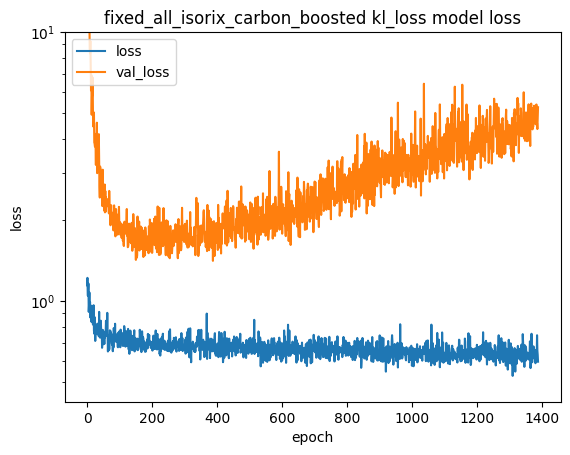

Val loss: 1.4119796752929688
Train loss: 0.684356689453125
[[25.2101955 2.01308393]
 [25.444416 2.01645303]
 [25.2737904 1.89819062]
 ...
 [nan -nan]
 [24.3138599 1.26072359]
 [25.2101612 2.01298237]]
[[nan nan]
 [24.4407177 1.36963642]]
Test loss: nan


ValueError: ignored

In [95]:
grouped_fixed_fileset = {
    'TRAIN' : os.path.join(FP_ROOT, 'amazon_sample_data/canonical/uc_davis_new_train_fixed_grouped.csv'),
    'TEST' : os.path.join(FP_ROOT, 'amazon_sample_data/canonical/uc_davis_new_validation_fixed_grouped.csv'),
    'VALIDATION' : os.path.join(FP_ROOT, 'amazon_sample_data/canonical/uc_davis_new_test_fixed_grouped.csv'),
}

columns_to_passthrough = []
columns_to_scale = []
columns_to_standardize = [
    'lat', 'long', 'vpd', 'rh', 'pet', 'dem', 'pa', 'd13C_cel', 'isorix',
    'Iso_Oxi_Stack_mean_TERZER',
    'isoscape_fullmodel_d18O_prec_REGRESSION']

data = load_and_scale(grouped_fixed_fileset, columns_to_passthrough, columns_to_scale, columns_to_standardize)
model = train_and_evaluate(data, "fixed_all_isorix_carbon_boosted", training_batch_size=3)
model.save(get_model_save_location("fixed_all_isorix_carbon_boosted.tf"), save_format='tf')
dump(data.feature_scaler, get_model_save_location('fixed_all_isorix_carbon_boosted.pkl'))